# **Table of Contents**
* [Exploration & Wrangling](#section_a)
    <br><br>
* [Model Building](#section_b)
    * [LOR](#section_21)
    * [KNN](#section_2)
    * [NB](#section_3)
    * [DT](#section_4)
    * [RF](#section_5)
    * [Bagging](#section_6)
    * [Boosting](#section_7)
    <br><br>
* [Model Selection](#section_c)
    * [Scores](#section_8)
    * [Rank](#section_9)
    * [Best Model](#section_10)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import scipy.stats       as stats 

import warnings
warnings.filterwarnings("ignore")

In [2]:
from  sklearn.linear_model     import   LogisticRegression
from  sklearn.naive_bayes      import   GaussianNB
from  sklearn.neighbors        import   KNeighborsClassifier
from  sklearn.tree             import   DecisionTreeClassifier
from  sklearn.ensemble         import   RandomForestClassifier , BaggingClassifier ,  AdaBoostClassifier , GradientBoostingClassifier ,  VotingClassifier


from  sklearn.preprocessing     import   StandardScaler
from  sklearn.model_selection   import   train_test_split , KFold , cross_val_score , GridSearchCV 

from  sklearn                   import   metrics

In [3]:
df = pd.read_csv ("datasets/Diabetes.csv", names =  ['preg', 'glu', 'bp', 'sft', 'ins', 'bmi', 'dpf', 'age', 'outcome'] )

df.sample(3)

,preg,glu,bp,sft,ins,bmi,dpf,age,outcome
473,7,136,90,0,0,29.9,0.210,50,0
610,3,106,54,21,158,30.9,0.292,24,0
663,9,145,80,46,130,37.9,0.637,40,1


**Target Col -- outcome**

<a id='section_a'></a>
# **Part I - Exploration & Wrangling**

In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   preg     768 non-null    int64  
 1   glu      768 non-null    int64  
 2   bp       768 non-null    int64  
 3   sft      768 non-null    int64  
 4   ins      768 non-null    int64  
 5   bmi      768 non-null    float64
 6   dpf      768 non-null    float64
 7   age      768 non-null    int64  
 8   outcome  768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.corr()

,preg,glu,bp,sft,ins,bmi,dpf,age,outcome
preg,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
glu,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
bp,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
sft,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
ins,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
bmi,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
dpf,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


>  Comments
    
        * Weakest Corr cols are
        * bp , sft

## i. **Weak Correlated columns**

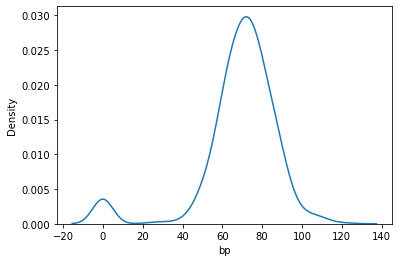

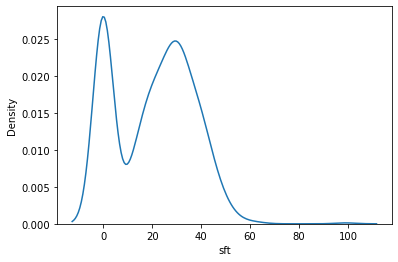

In [7]:
sns.kdeplot ( df['bp']  )
plt.show()

sns.kdeplot ( df['sft'] )
plt.show()

> Inference
    
        * Presence of zeroes in 'bp' col .....  means 'bp' has not been recorded for those patients

### **Imputation**

In [8]:
ls=[]

for i in df['bp']:
    if i>0:
        ls.append(i)

print(np.median(ls))    

72.0


In [9]:
for i in np.arange(df.shape[0]):
    
    if df['bp'][i]==0:
        df['bp'][i] = 72

### **Significance check of weak corr cols**

In [10]:
g1 = df [ df['outcome'] ==0 ]
g2 = df [ df['outcome'] ==1 ]

In [11]:
from  scipy.stats  import   ttest_ind 

print (   ttest_ind ( g1['bp']  , g2['bp'] )  )
print (   ttest_ind ( g1['sft'] , g2['sft'])  )

Ttest_indResult(statistic=-4.65097622072597, pvalue=3.8908354906479115e-06)
Ttest_indResult(statistic=-2.0747001964159613, pvalue=0.03834770482049123)


* Hence , both weak correlated columns are significant

## ii. **Target column**

In [12]:
df['outcome'].value_counts()

0    500
1    268
Name: outcome, dtype: int64

In [13]:
x  =  df.drop ('outcome' , axis=1)
y  =  df ['outcome']

In [14]:
from    imblearn.combine     import    SMOTEENN

cs   =  SMOTEENN ()                                     # cs ---> combined sampling

x,y  =  cs.fit_resample(x,y)

In [15]:
y.value_counts()

1    310
0    234
Name: outcome, dtype: int64

## iii. **Scaling**

In [16]:
from sklearn.preprocessing   import  StandardScaler
sc = StandardScaler()

x  = sc.fit_transform(x)

<a id='section_b'></a>
# **Part II - Model Building**

In [17]:
x_train, x_test, y_train, y_test  =  train_test_split (x, y, test_size =0.3, random_state =0)

kf  =  KFold (shuffle=True , n_splits=5 , random_state=0) 

<a id='section_21'></a>
## **1 - LOR**

In [18]:
LOR = LogisticRegression()           

<a id='section_2'></a>
## **2 - KNN**

### Finding best hyper-parameter

In [19]:
KNN = KNeighborsClassifier ()

param = { 'n_neighbors': np.arange(2,35)   ,   'weights':['uniform','distance'] } 

GS  =  GridSearchCV ( KNN , param , cv=kf , scoring='roc_auc' )

GS.fit (x_train , y_train)

GS.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

In [20]:
KNN = KNeighborsClassifier ( n_neighbors =10  ,  weights ='distance') 

<a id='section_3'></a>
## **3 - Naive Bayes**

In [21]:
NB = GaussianNB()

<a id='section_4'></a>
## **4 - Decision Tree**

### **4.1 - Fully Grown**

In [22]:
FDT = DecisionTreeClassifier (random_state=0)             

### **4.2 - Regularised**

* Finding best hyper-parameter

In [23]:
param = { 'max_depth': np.arange(1,20)   ,   'criterion':['entropy','gini'] } 

GS  =  GridSearchCV ( FDT , param , cv=kf , scoring='roc_auc')

GS.fit (x_train , y_train)

GS.best_params_

{'criterion': 'entropy', 'max_depth': 4}

In [24]:
RDT = DecisionTreeClassifier (criterion='entropy' , max_depth=4 ,  random_state=0)

<a id='section_5'></a>
## **5 - Random Forest**

* Finding best n_estimator for least VE

In [26]:
VE = []


for i in np.arange(1,25):
    
    RF = RandomForestClassifier ( n_estimators =i, criterion ='entropy', random_state =0 )
    
    score = cross_val_score ( RF ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    VE.append ( np.std(score,ddof=1) )
    
    
np.argmin(VE)

6

In [27]:
RF = RandomForestClassifier ( n_estimators=7 , criterion='entropy', random_state =0 )  

<a id='section_6'></a>
## **6 - Bagging**

### **6.1 - LOR_Bag**

In [28]:
LOR2 = LogisticRegression()

VE = []

for i in np.arange(1,25):                                                     # 10-15 %
    
    LOR_bag = BaggingClassifier   ( base_estimator = LOR2 , n_estimators =i, random_state =0 )
    
    score   = cross_val_score     ( LOR_bag ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    VE.append ( np.std(score,ddof=1) )
    

np.argmin(VE)

5

In [30]:
LOR_bag = BaggingClassifier   ( base_estimator = LOR2 , n_estimators =6, random_state =0 )

### **6.2 - NB_Bag**

In [31]:
NB2 = GaussianNB()

VE = []

for i in np.arange(1,25):
    
    NB_bag = BaggingClassifier ( base_estimator = NB2 , n_estimators =i, random_state =0 )
    
    score   = cross_val_score ( NB_bag ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    VE.append ( np.std(score,ddof=1) )
    
    
np.argmin(VE) 

20

In [32]:
NB_bag = BaggingClassifier ( base_estimator = NB2 , n_estimators =21, random_state =0 )

### **6.3 - KNN_Bag**

In [33]:
KNN2 = KNeighborsClassifier ()

VE = []

for i in np.arange(1,25):
    
    KNN_bag = BaggingClassifier ( base_estimator = KNN2 , n_estimators =i, random_state =0 )
    
    score   = cross_val_score ( KNN_bag ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    VE.append ( np.std(score,ddof=1) )
    

np.argmin(VE) 

22

In [34]:
KNN_bag  =  BaggingClassifier ( base_estimator = KNN2 , n_estimators =23 , random_state =0 )

<a id='section_7'></a>
## **7 - Boosting**

## **7.1 - AdaBoost**

### 7.1.1 - **Regularised DT boost** (default)

In [35]:
BE = []

for i in np.arange(1,25):                                                                    
    
    RDT_boost   =  AdaBoostClassifier   ( n_estimators =i, random_state =0 )      # default base_estimator : Reg DT
    
    score       =  cross_val_score      ( RDT_boost ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    BE.append ( np.mean(1-score)  )
    
    
np.argmin(BE)

20

In [36]:
RDT_boost =  AdaBoostClassifier   ( n_estimators =21, random_state =0 )   

### 7.1.2 - **RF boost**

* Hyper-param tuned RF model is now boosted

In [38]:
BE = []

for i in np.arange(1,35):                                                                    
    
    RF_boost =  AdaBoostClassifier ( base_estimator = RF, n_estimators =i, random_state =0 )                   
    
    score    = cross_val_score     ( RF_boost ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    BE.append ( np.mean(1-score)    )
    
    
np.argmin(BE)

27

In [39]:
RF_boost =  AdaBoostClassifier  ( base_estimator = RF , n_estimators =28, random_state =0 )

## **7.2 - XG Boost**

In [43]:
BE = []

for i in np.arange(1,65):                                                                    
    
    XG_boost =  GradientBoostingClassifier  ( n_estimators = i , random_state =0 )                                   
    
    score    =  cross_val_score             ( XG_boost ,  x_train ,  y_train ,  cv=kf,  scoring='roc_auc' )
    
    BE.append ( np.mean(1-score)    )
    
    
np.argmin(BE)

59

In [44]:
XG_boost =  GradientBoostingClassifier  ( n_estimators =60, random_state =0 ) 

<a id='section_c'></a>
# **Part III - Model Selection**

<a id='section_8'></a>
## i. **Scores**

In [45]:
models = []

models.append  (( 'LOR'       , LOR        ))
models.append  (( 'NB'        , NB         ))
models.append  (( 'KNN'       , KNN        ))



models.append  (( 'FDT'       , FDT        ))
models.append  (( 'RDT'       , RDT        ))
models.append  (( 'RF'        , RF         ))



models.append  (( 'LOR_bag'   , LOR_bag    ))
models.append  (( 'NB_bag'    , NB_bag     ))
models.append  (( 'KNN_bag'   , KNN_bag    ))


models.append  (( 'RDT_boost' , RDT_boost  ))
models.append  (( 'RF_boost'  , RF_boost   ))
models.append  (( 'XG_boost'  , XG_boost   ))

In [46]:
result =[]

for  i,j  in  models:
    
    score = cross_val_score ( j , x_train , y_train , cv =kf, scoring ='roc_auc' )
    
    result.append ( { 'Name': i   ,   'BE': np.mean(1-score)   ,   'VE': np.std(score,ddof=1)  } )                


table = pd.DataFrame(result)

<a id='section_9'></a>
## ii - **Rank**

### By least Bias Error

In [47]:
table.sort_values (by='BE')    .head(8)      .style.hide_index()

Name,BE,VE
RF_boost,0.017284,0.011324
XG_boost,0.020813,0.011851
RDT_boost,0.020903,0.013776
KNN,0.028696,0.011466
RF,0.033456,0.014202
KNN_bag,0.033673,0.008858
LOR,0.038753,0.025496
LOR_bag,0.039168,0.024798


### By least Variance Error

In [48]:
table.sort_values (by='VE')    .head(8)      .style.hide_index()

Name,BE,VE
KNN_bag,0.033673,0.008858
RF_boost,0.017284,0.011324
KNN,0.028696,0.011466
XG_boost,0.020813,0.011851
RDT_boost,0.020903,0.013776
RF,0.033456,0.014202
NB_bag,0.069767,0.023119
NB,0.072318,0.024501


<a id='section_10'></a>
## iii - **Best Model**

## *Random Forest Boosted*

In [49]:
RF_boost.fit      ( x_train , y_train )

y_pred   =   RF_boost.predict ( x_test )

In [50]:
print ( metrics.f1_score                ( y_pred , y_test ) )

print ( metrics.classification_report   ( y_pred , y_test ) )

0.9417989417989417
              precision    recall  f1-score   support

           0       0.94      0.90      0.92        71
           1       0.93      0.96      0.94        93

    accuracy                           0.93       164
   macro avg       0.93      0.93      0.93       164
weighted avg       0.93      0.93      0.93       164



In [51]:
print  ( y_test .value_counts()        )              # ACTUAL

print  ( pd .value_counts ( y_pred )   )              # PREDICTED

1    96
0    68
Name: outcome, dtype: int64
1    93
0    71
dtype: int64
